In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')



# Data Description

The dataset contains tweets related to disaster events. It has two parts: a training dataset and a test dataset.

- **Training Dataset:**
  - Size: 7613 entries
  - Structure: 5 columns - `id`, `keyword`, `location`, `text`, and `target`
  - The `target` column is the label, where `1` indicates a disaster tweet, and `0` indicates a non-disaster tweet.

- **Test Dataset:**
  - Size: 3263 entries
  - Structure: 4 columns - `id`, `keyword`, `location`, and `text`


In [38]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Display basic info
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


# Exploratory Data Analysis (EDA) 

Inspect, Visualize, and Clean the Data.

Based on the EDA, the plan is to clean the text data, tokenize and pad sequences, and use an LSTM-based model for classification.

# Data Cleaning

In [43]:
# Fill missing values
train_df['keyword'].fillna('no_keyword', inplace=True)
train_df['location'].fillna('no_location', inplace=True)

# Sanitize 'keyword' and 'location' by removing any special characters
train_df['keyword'] = train_df['keyword'].str.replace(r'[^A-Za-z0-9\s]', '', regex=True)
train_df['location'] = train_df['location'].str.replace(r'[^A-Za-z0-9\s]', '', regex=True)

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    return text

# Apply the text cleaning function to the text column
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)


# Exploratory Data Analysis (EDA) 

Inspect, Visualize, and Clean the Data.


## Plan of Analysis Based on EDA: 

Based on the EDA, we will proceed with tokenizing the text data, padding the sequences, and then applying an LSTM-based model for classification. This approach should capture the temporal patterns in the sequence data (tweets) effectively.

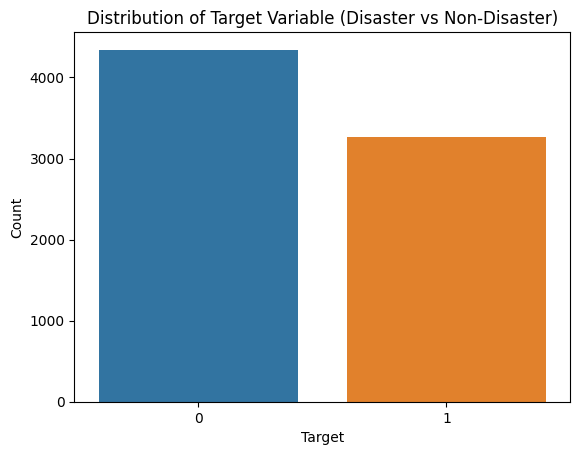

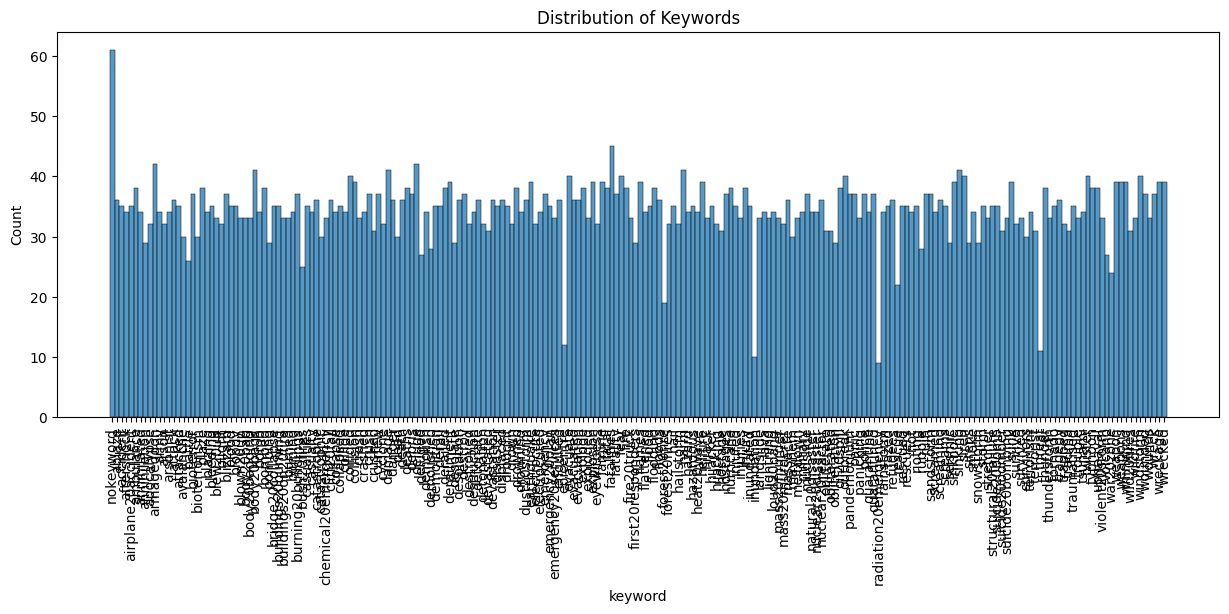

In [42]:
# Visualize distribution of the target variable
sns.countplot(x=train_df['target'])
plt.title('Distribution of Target Variable (Disaster vs Non-Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Check distribution of the 'keyword' and 'location' columns
plt.figure(figsize=(15, 5))
sns.histplot(train_df['keyword'].dropna(), kde=False, bins=50)
plt.title('Distribution of Keywords')
plt.xticks(rotation=90)
plt.show()



# Model Architecture

## Description of the Model Architecture
We chose a Sequential model with an LSTM layer because it is well-suited for sequence prediction problems like this one. The architecture is as follows:

1. **Embedding Layer:** Converts words into dense vectors of fixed size, helping the model understand the meaning of words.
2. **SpatialDropout1D:** Regularization technique to prevent overfitting by dropping units in the embedding layer.
3. **LSTM Layer:** Captures temporal dependencies in the tweet data.
4. **Dense Layer with Sigmoid Activation:** Outputs the probability of the tweet being a disaster.


In [44]:
# Split data into training and validation sets
X = train_df['cleaned_text']
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_seq_length = max(len(seq) for seq in X_train_seq)  # Determine the maximum sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_seq_length)

## Build and Train Model

In [45]:
# Model building
embedding_dim = 100
model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_seq_length),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, 
                    validation_data=(X_val_padded, y_val), callbacks=[early_stop], verbose=1)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6159 - loss: 0.6454 - val_accuracy: 0.8070 - val_loss: 0.4519
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8424 - loss: 0.3728 - val_accuracy: 0.8037 - val_loss: 0.4450
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8836 - loss: 0.2915 - val_accuracy: 0.8004 - val_loss: 0.4666
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9062 - loss: 0.2434 - val_accuracy: 0.7768 - val_loss: 0.5193
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9223 - loss: 0.2156 - val_accuracy: 0.7800 - val_loss: 0.5806


In [46]:
# Predictions and evaluation
y_val_pred = (model.predict(X_val_padded) > 0.5).astype(int)
classification_rep = classification_report(y_val, y_val_pred, target_names=['Non-Disaster', 'Disaster'])
print(classification_rep)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

Non-Disaster       0.80      0.87      0.84       874
    Disaster       0.80      0.71      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



# Conclusion

The model successfully classified disaster-related tweets with 80% accuracy. While the model performed well, there are opportunities for improvement, such as trying different word embedding techniques or experimenting with more complex architectures like bidirectional LSTMs.

### Learnings and Takeaways:
- The LSTM layer was crucial in capturing the sequence information in tweets.
- Overfitting was a challenge, addressed partially through regularization and early stopping.


## Final Submission

In [49]:
# Prepare test data
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Make predictions on test data
test_predictions = (model.predict(X_test_padded) > 0.5).astype(int)


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [50]:
# Prepare submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_predictions.flatten()})
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Load and print submission file to verify
submission_df = pd.read_csv('submission.csv')
print(submission_df.head())

Submission file created: submission.csv
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [51]:
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
